# Assignment 2: Perceptrons

## Given

In [1]:
# loading necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
    
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def derivative(f,x, eps = 1e-6):
    grad = (f(x+eps)-f(x-eps))/(2*eps)
    return grad

def sigmoid(z):
    return 'Not implemented'
def step(z):
    return 'Not implemented'
def tanh(z):
    return 'Not implemented'
def relu(z):
    return 'Not implemented'

def plot_activations():
    x = np.linspace(-5, 5, 200)

    plt.figure(figsize=(11,4))

    plt.subplot(121)
    plt.plot(x, step(x), "r-", linewidth=1, label="Step")
    plt.plot(x, sigmoid(x), "g--", linewidth=2, label="Sigmoid")
    plt.plot(x, tanh(x), "b-", linewidth=2, label="Tanh")
    plt.plot(x, relu(x), "m-.", linewidth=2, label="ReLU")
    plt.grid(True)
    plt.title("Activation functions", fontsize=14)
    plt.axis([-5, 5, -1.2, 1.5])

    plt.subplot(122)
    plt.plot(x, derivative(step, x), "r-", linewidth=1, label="Step")
    plt.plot(x, derivative(sigmoid, x), "g--", linewidth=2, label="Sigmoid")
    plt.plot(x, derivative(tanh, x), "b-", linewidth=2, label="Tanh")
    plt.plot(x, derivative(relu, x), "m-.", linewidth=2, label="ReLU")
    plt.grid(True)
    plt.title("Gradients", fontsize=14)
    plt.axis([-5, 5, -0.2, 1.2])
    plt.legend(loc='upper right',fontsize=14,bbox_to_anchor=(1.5, 1), ncol=1)

    plt.show()
    
def show_image(index, data_x, data_y):
    example = data_x[index]
    plt.imshow(data_x[index])
    print ("y = " + str(data_y[:, index]) + ", '" + classes[np.squeeze(data_y[:, index])].decode("utf-8") +  "' picture.")

    
def show_mistake(index, data_x, data_y, d):
    plt.imshow(data_x[:,index].reshape((num_px, num_px, 3)))
    print ("y = " + str(data_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

def plot_training(d):
    costs = np.squeeze(d['costs'])
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(d["learning_rate"]))
    plt.show()


## Exercise 1: Preparing Data (2 Points)


### Loading a Dataset

First we load a dataset containing images with labels for cat and non cat.
You can change the index to view different images.

(If you are not running this on Google Colab download the data manually, store them in a folder called 'datasets' and only execute the last line of the following cell)


In [2]:
# download data from google drive
# for loading from google drive
!pip install gdown
# output directory
!mkdir datasets
!gdown https://drive.google.com/uc?id=1-XOTnNs4hcVRAb-sT2O02YqBhT2QY2d1 -O datasets/train_catvnoncat.h5 # training data
!gdown https://drive.google.com/uc?id=11sDVqnSupkCl54chSitnGlrbLtvsuwgH -O datasets/test_catvnoncat.h5 # test data
 # loading dataset
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Downloading...
From: https://drive.google.com/uc?id=1-XOTnNs4hcVRAb-sT2O02YqBhT2QY2d1
To: /content/datasets/train_catvnoncat.h5
2.57MB [00:00, 82.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=11sDVqnSupkCl54chSitnGlrbLtvsuwgH
To: /content/datasets/test_catvnoncat.h5
100% 617k/617k [00:00<00:00, 87.6MB/s]


y = [1], 'cat' picture.


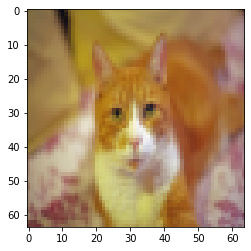

In [7]:
index = 24

show_image(index, train_set_x_orig, train_set_y)

Now we want to take a look into the dataset.

In [8]:
# Extracting the shapes of the training and the test set

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


### 1. Preprocessing the Data (1 Point)

To feed the data into our network later on, we have to format every data point, which are currently of the shape (64,64,3) into row-vectors.

**Exercise**:
Write the code to flatten the input data.
A trick when you want to flatten a matrix $X$ of shape (a,b,c,d) to a matrix $X_{flatten}$ of shape (b$*$c$*$d, a) is to first reshape it in a (a,b$*$c$*$d) and then transpose it.


In [9]:
# Reshape the data of the training and test set

train_set_x_height = train_set_x_orig.shape[1]
train_set_x_width = train_set_x_orig.shape[2]
train_set_x_rgb = train_set_x_orig.shape[3]

test_set_x_height = test_set_x_orig.shape[1]
test_set_x_width = test_set_x_orig.shape[2]
test_set_x_rgb = test_set_x_orig.shape[3]

train_set_x_flatten = np.reshape(train_set_x_orig, (m_train, train_set_x_height*train_set_x_width*train_set_x_rgb)).T
test_set_x_flatten = np.reshape(test_set_x_orig, (m_test, test_set_x_height*test_set_x_width*test_set_x_rgb)).T


print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


**Expected Output**: 

`train_set_x_flatten shape: (12288, 209)`

`train_set_y shape: (1, 209)`

`test_set_x_flatten shape: (12288, 50)`

`test_set_y shape: (1, 50)`


### 2. Normalization (1 Point)

As a last step we want to normalize the RGB channels of the images.

**Exercise**:
Currently they are integers ranging from 0 to 255, we will normalize them to the range 0 to 1.

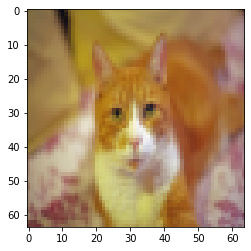

In [11]:
train_set_x = (train_set_x_flatten)/255.0
test_set_x = (test_set_x_flatten)/255.0
index = 24
plt.imshow(train_set_x[:,index].reshape((num_px, num_px, 3)))

## Exercise 2: Building Perceptrons (22 Points)


### 1. Activation Functions (4 Points)

Next we want to implement different activation functions.

**Exercise:** 
Write functions for the Sigmoid, the Rectified Linear Unit, the Hyperbolic tangent and the step function, that support broadcasting.

Look up suitable [Numpy](https://docs.scipy.org/doc/numpy-1.10.1/search.html) functions.

In [12]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

def relu(x):
    
    return x * (x > 0)

def tanh(x):
    
    return np.tanh(x)

def step(x):
    
    return 1*(x>0.5)

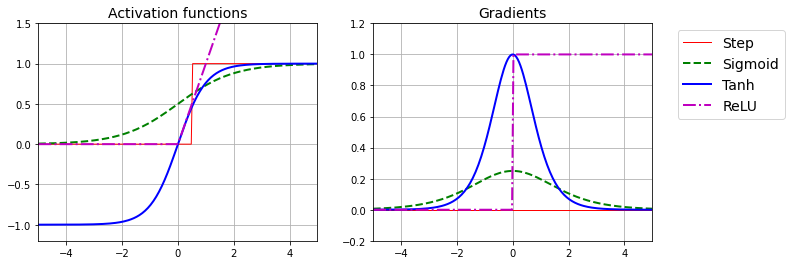

In [ ]:
plot_activations()

### 2. Loss Function (1 Point)

Next we need a loss function for our network, we will use the cross entropy loss, also called negative log-likelihood

$$ \mathcal{L}(y, \hat y) = -y \ln(\hat y) - (1-y)\ln(1-\hat y). $$

**Exercise**:
Write a function to return the loss.

In [16]:
def crossentropy_loss(y,yhat):
    '''
    Computes the Cross Entropy-Loss or Negative Log-Likelihood elementwise between y and yhat.
    
    Arguments:
    y - A numpy array
    yhat -  A numpy array of the same shape a y
    
    Returns:
    L - A numpy array of the same shape as y
    '''

    return (-y*np.log(yhat))-(1-y)*np.log(1-yhat)

In [ ]:
y = np.array([0,1,0])
yhat = np.array([0.1,0.4,0.9])
print(crossentropy_loss(y,yhat))

[0.10536052 0.91629073 2.30258509]


**Expected output**:

`[0.10536052 0.91629073 2.30258509]`


### 3. Initializing Parameters (2 Points)

First we have to initialize the parameters of the Perceptron.

**Exercise:** Implement the parameter initialization for a single Perceptron.

Try using `np.zeros`


In [14]:
def initialize_with_zeros(dim):
    '''
    Initializes the parameters of a Perceptrons. 
    w as a vector of zeros of shape (dim, 1) b as 0.0 .
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    '''
    w = np.zeros((dim,1))
    b = 0
    
    return w,b

In [15]:
dim = 2
w, b = initialize_with_zeros(dim)
print(w)
print(b)

[[0.]
 [0.]]
0


**Expected output**:

`[[0.]`

` [0.]]`

`0`

### 4. Forward and Backward Propagation of a Perceptron (5 Points)

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- Compute the output $\hat Y = \sigma(w^T X + b)$
- Calculate the cost function: $J = \frac{1}{m}\sum_{i=1}^{m}\mathcal L (y_i, \hat y_i)$

Backward propagation: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(\hat Y-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (\hat y_i-y_i)$$



If you are interested in how to get the formula for the gradients, see [here](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression).

In [17]:
def perceptron_propagate(w, b, X, Y):
    '''
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- A numpy array of size (dim, 1), the weights
    b -- A scalar, the bias
    X -- A numpy array of shape (dim, m), the data
    Y -- A numpy array of shape (1, m), the labels (containing 0 if non-cat, 1 if cat)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- A numpy array of the same shape as w, gradient of the loss with respect to w
    db -- A numpy array of shape (1,), gradient of the loss with respect to b

    '''
    yhat = sigmoid(np.dot(w.T,X)+b)
    cost = np.sum(crossentropy_loss(Y,yhat)/Y.shape[1])

    dw = 1/Y.shape[1]*np.dot(X,(np.subtract(yhat,Y)).T)
    db = 1/Y.shape[1]*np.sum(np.subtract(yhat,Y))
    
    return cost,dw,db

In [ ]:
w, b, X, Y = np.array([[-1],[1]]), 0, np.array([[1,2],[3,4]]), np.array([[1,0]])
cost, dw, db = perceptron_propagate(w, b, X, Y)
print ("dw = " + str(dw))
print ("db = " + str(db))
print ("cost = " + str(cost))

dw = [[0.82119562]
 [1.58278977]]
db = 0.3807970779778823
cost = 1.126928011042972


**Expected output**:

`dw = [[0.82119562]`

` [1.58278977]]`

`db = [0.38079708]`

`cost = 1.126928011042972`

### 5. Optimization (4 Points)
The next step is the the actual optimization of the parameters using gradient descent.

**Exercise:** 

Complete the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. 
Remember that the update rule is$$ \theta = \theta - \eta \cdot d\theta.$$
Also include a function to print the cost every 100 steps, if `print_cost == True`.



In [18]:
def perceptron_optimize(w, b, X, Y, num_steps, learning_rate, print_cost = False):
    '''
    This function optimizes the parameters of the perceptron w and b using gradient descent.
    
    Arguments:
    w -- A numpy array of size (dim, 1), the weights
    b -- A scalar, the bias
    X -- A numpy array of shape (dim, m), the data
    Y -- A numpy array of shape (1, m), the labels (containing 0 if non-cat, 1 if cat)
    num_steps -- An integer, the number of steps in the optimization loop
    learning_rate -- A float, learning rate for the gradient descent
    print_cost -- A Boolean, True to print the loss every 100 steps
    
    Returns:
    params -- dictionary, containing the weights w and bias b
    grads -- dictionary, containing the gradients of the weights and bias with respect to the cost function
    costs -- list, cost of every 100th step.
    '''
    costs = []
    for step in range(num_steps):
        cost, dw, db = perceptron_propagate(w, b, X, Y)
        costs.append(cost)
        w = w - learning_rate * dw
        b = b - learning_rate * db
          
        if print_cost and step%100 == 0:
            print(cost)

    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
params, grads, costs = perceptron_optimize(w, b, X, Y, num_steps= 100, learning_rate = 0.009, print_cost = False)

print ('w = ' + str(params['w']))
print ('b = ' + str(params['b']))
print ('dw = ' + str(grads['dw']))
print ('db = ' + str(grads['db']))

w = [[-1.31346227]
 [ 0.52901232]]
b = -0.07876270244512314
dw = [[0.13198295]
 [0.03846422]]
db = -0.04675936359765406


**Expected Output**:

`w = [[-1.31346227]`

`[ 0.52901232]]`

`b = [-0.0787627]`

`dw = [[0.13198295]`

`[0.03846422]]`

`db = [-0.04675936]`


### 6. Prediction (2 Points)

The last missing step is a function to give predictions based on the network output.

**Exercise**: 
For this complete the function to return a 0 if $\hat y \leq 0.5$ and 1 if $\hat y > 0.5$.
- Avoid a for-loop.

In [19]:
def perceptron_predict(w, b, X):
    '''
    Predict labels for the input data based on the given parameters
    
    Arguments:
    w -- A numpy array of size (dim, 1), the weights
    b -- A scalar, the bias
    X -- A numpy array of shape (dim, m), the data
    
    Returns:
    Y_prediction -- A numpy array of shape (1,m), the  predictions (containing 0 if non-cat, 1 if cat)
    Yhat -- A numpy array of shape (1,m), the predicted probabilities
    '''      
    Yhat = sigmoid((np.dot(np.transpose(w),X) + b))
    Y_prediction = step(Yhat)

    return Y_prediction, Yhat

In [ ]:
Y_pred, Y_prob = perceptron_predict(w,b,X)
print ("probabilites = " + str(Y_prob))
print ("predictions = " + str(Y_pred))

probabilites = [[0.88079708 0.88079708]]
predictions = [[1 1]]


**Expected Output**:

` 
probabilites = [[0.88079708 0.88079708]]`

`predictions = [[1 1]]
` 

### 7. Build the complete Perceptron (4 Points)

We will now put all our building blocks together to form a model

**Exercise**:
Use your previously build functions to complete the model.

In [20]:
def model(X_train, Y_train, X_test, Y_test, num_steps = 2000, learning_rate = 0.5, print_cost = False):
    '''
    Builds the logistic regression model by calling the functions you've implemented previously
    
    Arguments:
    X_train -- A numpy array of shape (dim, m_train), the training data
    Y_train -- A numpy array of shape (1, m_train), the training labels (containing 0 if non-cat, 1 if cat)
    X_test -- A numpy array of shape (dim, m_test), the test data
    Y_test -- A numpy array of shape (1, m_test), the test labels (containing 0 if non-cat, 1 if cat)
    num_steps -- An integer, the number of steps in the optimization loop
    learning_rate -- A float, learning rate for the gradient descent
    print_cost -- A Boolean, True to print the loss every 100 steps
    
    Returns:
    d -- dictionary, containing information about the model.
    '''
    
    # use the variable names as shown below in d
    ### START CODE HERE ###
    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = perceptron_optimize(w, b, X_train, Y_train, num_steps = num_steps, learning_rate = learning_rate, print_cost = print_cost)

    Y_prediction_train, train_prob = perceptron_predict(params['w'],params['b'],X_train)
    Y_prediction_test, test_prob = perceptron_predict(params['w'],params['b'],X_test)
    
    ### END CODE HERE ###

    # Print train/test Errors
    print('train accuracy: {} %'.format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print('test accuracy: {} %'.format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {'costs': costs,
         'Y_prediction_test': Y_prediction_test, 
         'Y_prediction_train' : Y_prediction_train, 
         'w' : w, 
         'b' : b,
         'learning_rate' : learning_rate,
         'num_iterations': num_steps}
    plot_training(d)
    
    return d

### Run the model

0.6931471805599452
0.5845083636993087
0.46694904094655476
0.3760068669480208
0.33146328932825125
0.30327306747438293
0.27987958658260487
0.26004213692587574
0.2429406846779662
0.22800422256726066
0.21481951378449637
0.20307819060644988
0.19254427716706862
0.18303333796883509
0.17439859438448874
0.16652139705400332
0.15930451829756614
0.15266732471296504
0.1465422350398234
0.14087207570310156
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


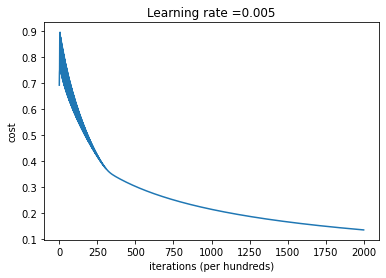

In [23]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_steps = 2000, learning_rate = 0.005, print_cost = True)


**Expected Output**:

`train accuracy: 99.043062201 %`

`test accuracy: 70.0 %`

y = 0, you predicted that it is a "cat" picture.


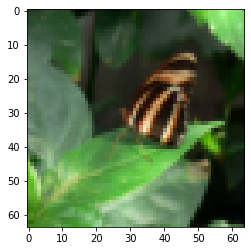

In [27]:
# Example of a picture that was wrongly classified.
index = 5
show_mistake(index, test_set_x, test_set_y, d)